In [1]:
%matplotlib inline
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import plotly.graph_objects as go
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
# always make it pretty 
plt.style.use('ggplot')
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [2]:
db = global_connect()

In [3]:
tables = ['itinerary', 'availability', 'driver', 'unmatched', 'rejected', 'av2it']
tables = {t: {'cols':[], 'rows': 0} for t in tables}
for t in tables.keys():
    tables[t]['cols'] = careful_query('select * from {} limit 1'.format(t)).columns.tolist()
    tables[t]['rows'] = careful_query('select count(*) as rows from {}'.format(t), 800000).iloc[0,0]
tables

{'itinerary': {'cols': ['itinerary_id',
   'driver_id',
   'created_time',
   'accepted_time',
   'cancellation_time',
   'dropped_time',
   'started_time',
   'finished_time',
   'status',
   'distance',
   'transport_type',
   'product',
   'product_version',
   'distribution_center',
   'packages',
   'delivered_packages',
   'checked_in_time',
   'pickup_checkout_time',
   'pickup_lat',
   'pickup_lng',
   'waypoints',
   'created_time_datetime',
   'finished_time_datetime'],
  'rows': 37061},
 'availability': {'cols': ['distribution_center',
   'id',
   'driver_id',
   'lat',
   'lng',
   'sent_f'],
  'rows': 33742545},
 'driver': {'cols': ['driver_id',
   'created',
   'onboard_date',
   'activation_date',
   'marital_status',
   'is_trunk_rented',
   'is_thermal_bag_rented',
   'has_thermal_bag',
   'has_loggi_trunk',
   'gender',
   'transport_type',
   'city',
   'operational_status',
   'trunk_capacity',
   'rescinded_date',
   'email_is_verified',
   'age',
   'vehicle_licen

In [4]:
agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82', '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}

### Load unique itineraries and drivers from itineraries datasets

In [5]:
I1_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM itinerary
WHERE distribution_center = '{}';
""".format(agency['1'])).itineraries.values)

I1_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM itinerary
WHERE distribution_center = '{}';
""".format(agency['1'])).drivers.values)

I2_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM itinerary
WHERE distribution_center = '{}';
""".format(agency['2'])).itineraries.values)

I2_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM itinerary
WHERE distribution_center = '{}';
""".format(agency['2'])).drivers.values)

### Load unique itineraries and drivers from availabilities + av2it datasets

In [6]:
A1_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM av2it
WHERE distribution_center = '{}';
""".format(agency['1']), 320000).itineraries.values)

A1_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM availability
WHERE distribution_center = '{}';
""".format(agency['1']), 1000000).drivers.values)

A2_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM av2it
WHERE distribution_center = '{}';
""".format(agency['2']), 320000).itineraries.values)

A2_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM availability
WHERE distribution_center = '{}';
""".format(agency['2']), 1050000).drivers.values)


### Load unique drivers from drivers dataset

In [7]:
D_d = set(careful_query("""SELECT DISTINCT(driver_id) AS driver FROM driver;""").driver.values)

### Generate new dataframe with count unique information
- itinerary_id and driver_id are two main ID that relate the datasets, so we will look directly into them

In [8]:
data = {
        'A1': [len(A1_i),
               len(A1_d)],
        'A2': [len(A2_i),
               len(A2_d)],
        'A1 ∪ A2': [len(A1_i | A2_i),
                    len(A1_d | A2_d)],        
        'A1 ∩ A2': [len(A1_i & A2_i),
                    len(A1_d & A2_d)],
        'I1': [len(I1_i),
               len(I1_d)],
        'I2': [len(I2_i),
               len(I2_d)],
        'I1 ∪ I2': [len(I1_i | I2_i),
                    len(I1_d | I2_d)],
        'I1 ∩ I2': [len(I1_i & I2_i),
                    len(I1_d & I2_d)],
        'D': [0, len(D_d)],
        'D ∪ I1 ∪ I2': [0,
                    len(I1_d | I2_d | D_d)],
        'D ∩ (I1 ∪ I2)': [0,
                    len((I1_d | I2_d) & D_d)],            
       }

df = pd.DataFrame(data, index=['unique itineraries', 'unique drivers'])

**Symbols reference**
- **A1**: agency 1 availabilities dataset
- **A2**: agency 2 availabilities dataset
- **I1**: agency 1 itineraries dataset
- **I2**: agency 2 itineraries dataset
- **D** driver dataset
- **∪**: union operator
- **∩**: intersection operator

In [9]:
df.style.applymap(lambda x: 'background-color:red; color:yellow' if x > 0 else '',
                subset = ['I1 ∩ I2', 'A1 ∩ A2'])

,A1,A2,A1 ∪ A2,A1 ∩ A2,I1,I2,I1 ∪ I2,I1 ∩ I2,D,D ∪ I1 ∪ I2,D ∩ (I1 ∪ I2)
unique itineraries,29,20,49,0,19335,17726,37061,0,0,0,0
unique drivers,12203,20553,21315,11441,1611,3929,5077,463,22029,22029,5077


## Unique itineraries found in Loggi's itinerary and availabilities datasets

In [10]:
colors = ['#99ff99', '#9999ff']
WEIGHTED = False

def plot6(sets):
    fig, axes = plt.subplots(2, 3, figsize=(16,9))
    axes = axes.flatten()
    for i, g in enumerate(sets):
        if WEIGHTED:
            venn2(list(g.values()), set_labels = list(g.keys()), set_colors=colors, ax=axes[i]);
            venn2_circles(list(g.values()), linewidth=1, ax=axes[i]);
        else:
            venn2_unweighted(list(g.values()), set_labels = list(g.keys()), set_colors=colors, ax=axes[i]);
            venn2_circles((1,1,1), linewidth=1, ax=axes[i]);

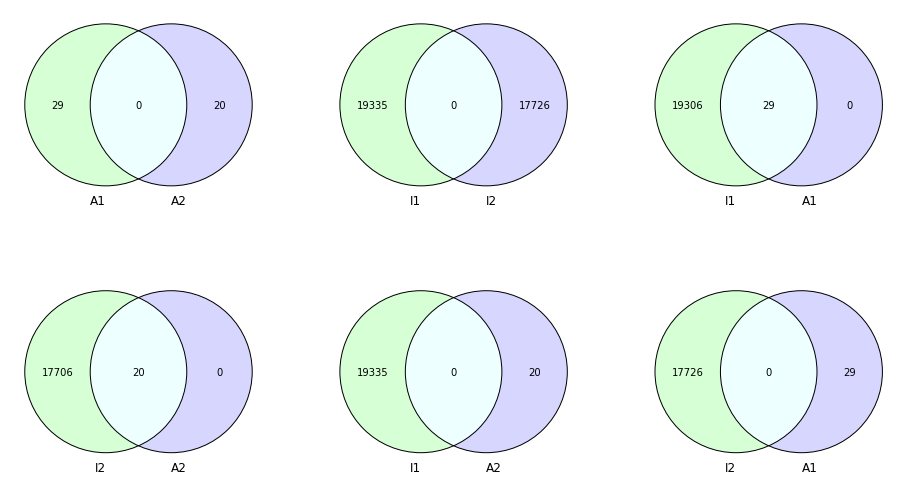

In [11]:
itineraries_sets = [
    {'A1': A1_i, 'A2': A2_i},
    {'I1': I1_i, 'I2': I2_i},
    {'I1': I1_i, 'A1': A1_i},
    {'I2': I2_i, 'A2': A2_i},
    {'I1': I1_i, 'A2': A2_i},
    {'I2': I2_i, 'A1': A1_i}
]
plot6(itineraries_sets)

**The above Venn's diagrams suggest that:**
- **A1, A2**: This is bad. After some research we detected that the availabilities_to_itineraries dataset is wrong. Once more we recived bad datasets. Maybe somebody is worry about keeping his/her job. We are not looking for your job, please. So we will try to regenerate something similar to this dataset using the driver_id and the itinerary created and finished date times in itinerary dataset (we hope the itinerary dataset is right).
- **I1, I2**: This is logical. There are no itineraries registered in both agencies.
- **I1, A1**: This is not good. We will try to fix this as mentioned above.
- **I2, A2**: This is not good. We wil try to fix this as mentioned above.
- **I1, A2**: This is not good. We wil try to fix this as mentioned above.
- **I2, A1**: This is not good. We wil try to fix this as mentioned above.

## Unique drivers found in Loggi's itineraries and availabilities datasets

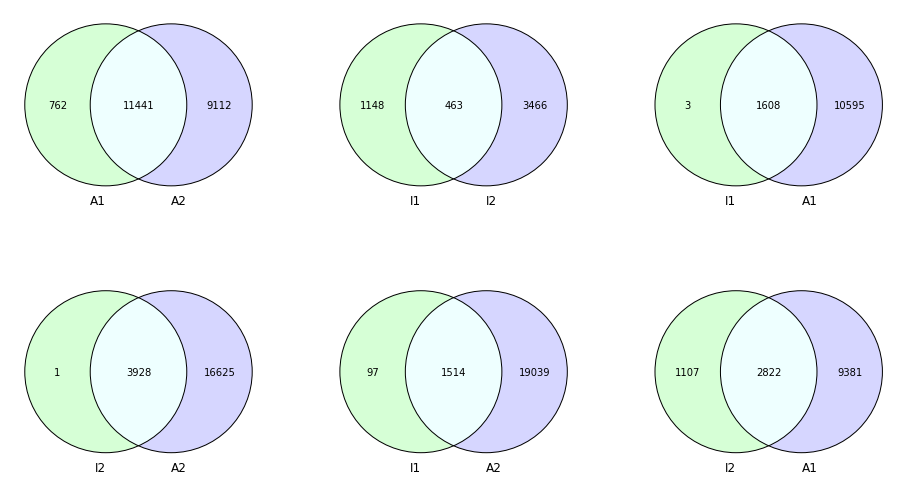

In [12]:
drivers_sets = [
    {'A1': A1_d, 'A2': A2_d},
    {'I1': I1_d, 'I2': I2_d},
    {'I1': I1_d, 'A1': A1_d},
    {'I2': I2_d, 'A2': A2_d},
    {'I1': I1_d, 'A2': A2_d},
    {'I2': I2_d, 'A1': A1_d}
]

plot6(drivers_sets)

**The above Venn's diagrams suggest that:**
- **A1, A2**: [comments]  
- **I1, I2**: [comments]  
- **I1, A1**: [comments]
- **I2, A2**: [comments]
- **I1, A2**: [comments]
- **I2, A1**: [comments]

In [13]:
print(careful_query("""select min(sent_f) as first, max(sent_f) as last from availability"""))

                first                last
0 2019-10-01 21:00:00 2020-03-25 10:50:00


In [14]:
# Trim first and last dates because they contain partial information
df = careful_query("""
SELECT DATE(sent_f) as date, COUNT(1) as messages, COUNT(DISTINCT(driver_id)) as drivers
FROM availability
WHERE sent_f > '2019-10-02' AND sent_f < '2020-03-25'
GROUP BY DATE(sent_f), distribution_center
HAVING distribution_center = '{}'
ORDER BY date
""".format(agency['1']), 2250000)

In [15]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [16]:
df.head()

,messages,drivers
date,,
2019-10-02,34381,1256
2019-10-03,35194,1264
2019-10-04,32052,1352
2019-10-05,19403,561
2019-10-06,12531,329


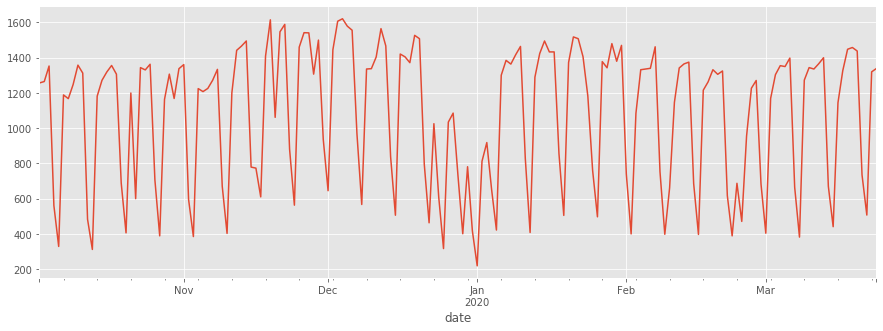

In [17]:
df['drivers'].plot(figsize=(15,5));

In [18]:
df.isna().sum()

messages    0
drivers     0
dtype: int64

In [19]:
dow = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
df['DOW'] = df.index.dayofweek
df_Xy = df[['drivers', 'DOW']].copy()
df_Xy = pd.concat([df_Xy, pd.get_dummies(df_Xy['DOW'], drop_first=True)], axis=1)
df_Xy = df_Xy.rename(columns={i : dow[i] for i in range(7)})
del df_Xy['DOW']
#df_Xy['ratio'] = df['messages'] / df['drivers']

In [20]:
df_Xy.head()

,drivers,tuesday,wednesday,thursday,friday,saturday,sunday
date,,,,,,,
2019-10-02,1256,0,1,0,0,0,0
2019-10-03,1264,0,0,1,0,0,0
2019-10-04,1352,0,0,0,1,0,0
2019-10-05,561,0,0,0,0,1,0
2019-10-06,329,0,0,0,0,0,1


In [21]:
holidays = [
    ('2019-01-01', 'New Year Day'),
    ('2019-03-04', 'Carnival'),
    ('2019-03-05', 'Carnival'),
#    ('2019-04-19', 'Good Friday'),
#    ('2019-04-21', 'Tiradentes Day'),
    ('2019-05-01', 'Labour Day'),
#    ('2019-06-20', 'Corpus Christi'),
    ('2019-09-07', 'Independece Day'),
#    ('2019-10-12', 'Our Lady of Aparecida'),
#    ('2019-11-02', 'All Souls Day'),
#    ('2019-11-15', 'Republic Day'),
#    ('2019-11-20', 'Black Consciousness Day (Only in Rio?)'),
    ('2019-12-25', 'Christmas Day'),
    ('2019-12-31', 'Last Year Day'),
    ('2020-01-01', 'New Year Day'),
    ('2020-01-25', 'Sao Paulo Birthday (no working day for agency 1)'),    
    ('2020-02-24', 'Carnival'),
    ('2020-02-25', 'Carnival')
]
# (*) Carnival, Good Friday and Corpus Christi are optional holidays, known as Ponto facultativos.

df_Xy['holiday'] = 0

for h in [h[0] for h in holidays]:
    d = pd.to_datetime(h)
    if d in df_Xy.index:
        df_Xy.loc[d, 'holiday'] = 1

In [22]:
df_Xy['drivers_prev_day'] = df_Xy['drivers']
df_Xy.reset_index(inplace=True) #, drop=True)

for i in range(1, len(df_Xy)):
    df_Xy.loc[i, 'drivers_prev_day'] = df_Xy.loc[i-1, 'drivers']

df_Xy.set_index('date', inplace=True)
df_Xy.head()

,drivers,tuesday,wednesday,thursday,friday,saturday,sunday,holiday,drivers_prev_day
date,,,,,,,,,
2019-10-02,1256,0,1,0,0,0,0,0,1256
2019-10-03,1264,0,0,1,0,0,0,0,1256
2019-10-04,1352,0,0,0,1,0,0,0,1264
2019-10-05,561,0,0,0,0,1,0,0,1352
2019-10-06,329,0,0,0,0,0,1,0,561


In [23]:
df_Xy.tail()

,drivers,tuesday,wednesday,thursday,friday,saturday,sunday,holiday,drivers_prev_day
date,,,,,,,,,
2020-03-20,1437,0,0,0,1,0,0,0,1457
2020-03-21,735,0,0,0,0,1,0,0,1437
2020-03-22,507,0,0,0,0,0,1,0,735
2020-03-23,1319,0,0,0,0,0,0,0,507
2020-03-24,1338,1,0,0,0,0,0,0,1319


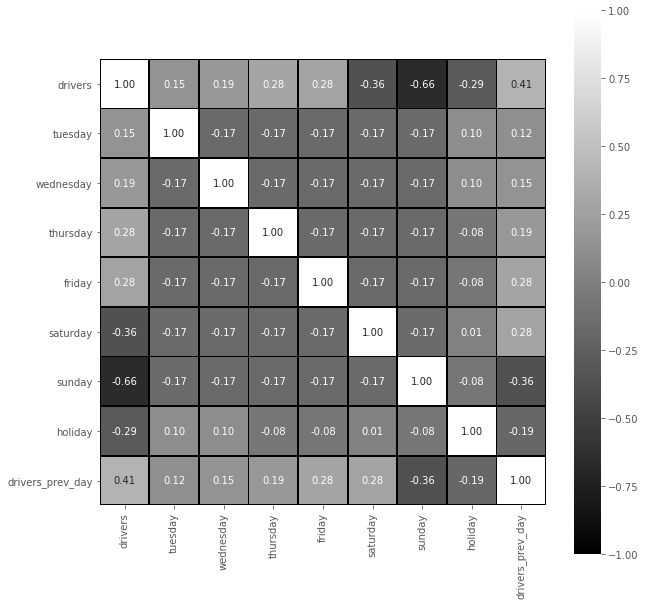

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(df_Xy.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

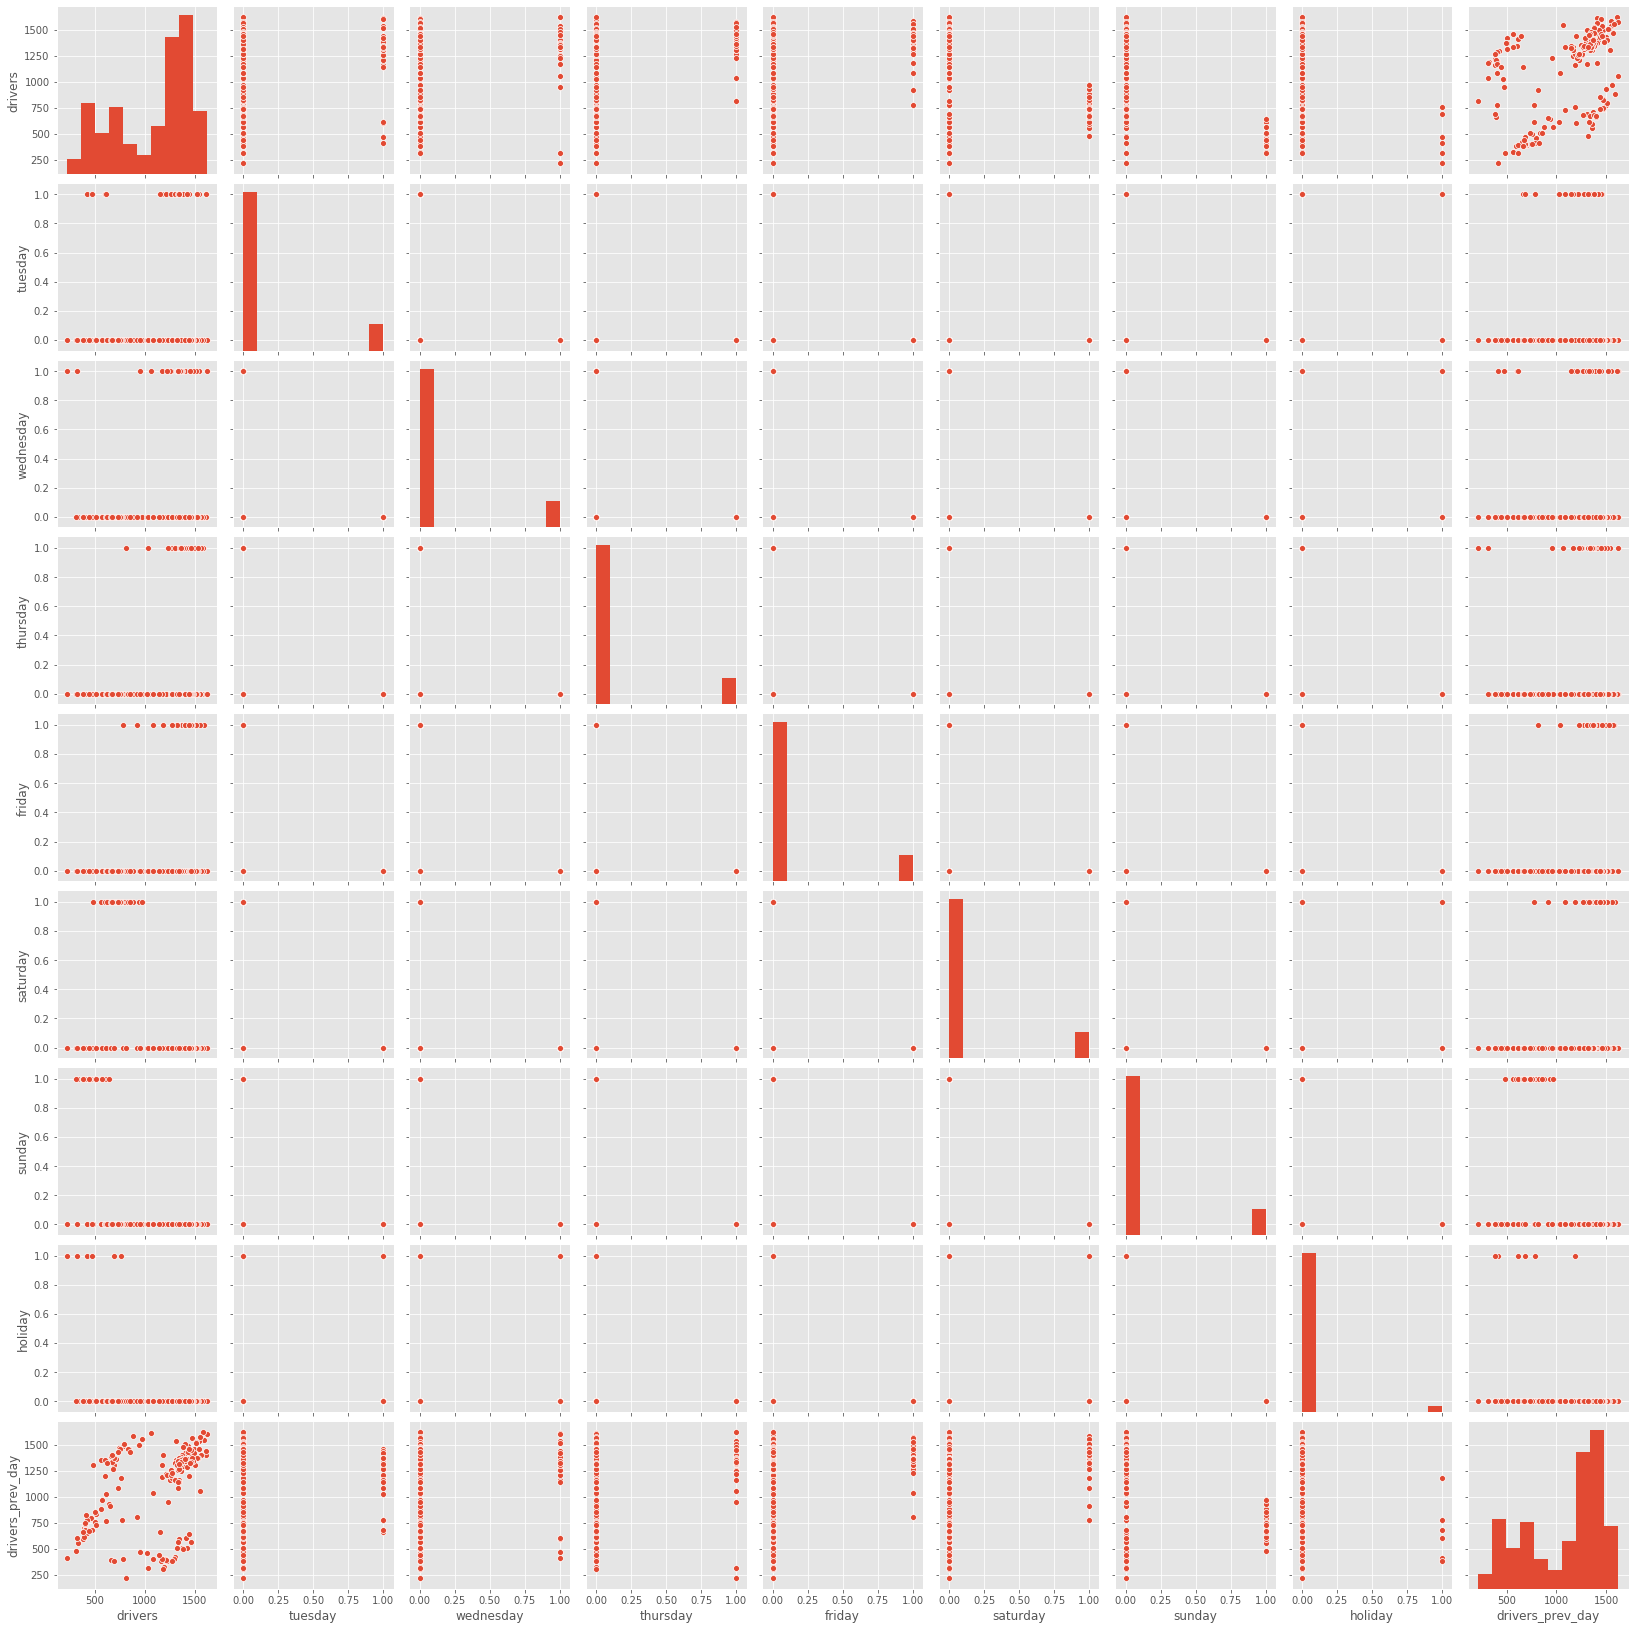

In [25]:
sns.pairplot(df_Xy);

In [26]:
df_Xy.shape

(175, 9)

In [27]:
# We have 175 days, so we will use 120 to train the model
train = df_Xy[:120]
test = df_Xy[120:]
dates = df_Xy.index.tolist()
dates_train = dates[:120]
dates_test = dates[120:]

In [28]:
formula = 'drivers ~ ' + ' + '.join([col for col in df_Xy if col not in ['drivers']])
print(formula)
model = smf.ols(formula = formula, data = train).fit()
print(model.summary())

drivers ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + drivers_prev_day
                            OLS Regression Results                            
Dep. Variable:                drivers   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     68.17
Date:                Mon, 04 May 2020   Prob (F-statistic):           2.68e-39
Time:                        00:40:44   Log-Likelihood:                -782.07
No. Observations:                 120   AIC:                             1582.
Df Residuals:                     111   BIC:                             1607.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

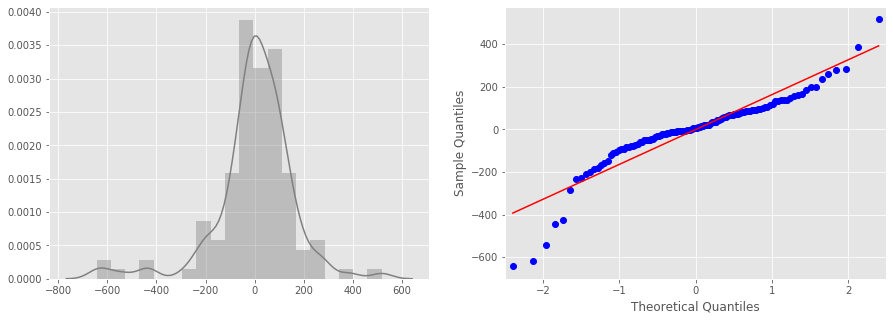

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(model.resid, bins=20, hist=True, ax=axes[0], color='gray');
idx = model.resid.abs() > model.resid.mean() + 4 * model.resid.std()
sns.rugplot(model.resid[idx], ax=axes[0], color='red')
sm.qqplot(model.resid, line="s", ax=axes[1]);

{'Intercept': 1016.424436398363,
 'tuesday': -400.5050191730912,
 'wednesday': -373.3687947141184,
 'thursday': -305.49986611295947,
 'friday': -401.48225494910395,
 'saturday': -933.4564128721229,
 'sunday': -948.3414077374748,
 'holiday': -459.25262232652295,
 'drivers_prev_day': 0.5230808579215873}

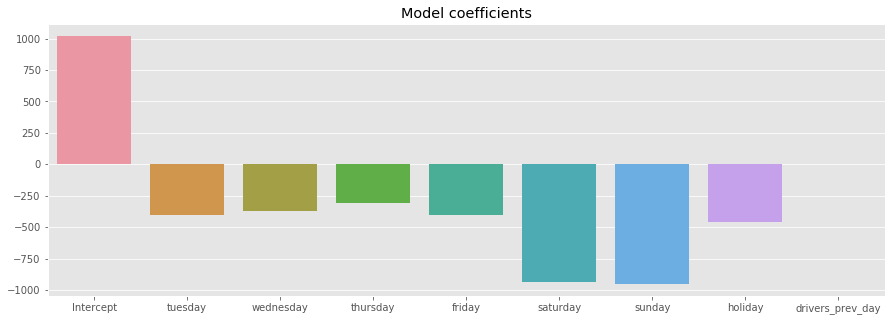

In [30]:
sel = {k: v for k, v in model.params.items()}
plt.figure(figsize=(15,5))
sns.barplot(x=list(sel.keys()), y=list(sel.values()));
plt.title('Model coefficients');
sel

In [31]:
mean_squared_error(model.predict(test), test['drivers'])

12605.012057239172

In [32]:
import scipy

def boxcox_help(data):
    _, λ = scipy.stats.boxcox(data)
    λ = round(λ, 2)
    if abs(λ) < 0.1:
        return 'Use np.log(y)'
    else:
        return 'Use np.power(y, λ={})'.format(round(λ, 2))

In [33]:
boxcox_help(train['drivers'])

'Use np.power(y, λ=1.58)'

In [34]:
formula = 'np.sqrt(drivers) ~ np.sqrt(drivers_prev_day) + ' + ' + '.join(dow[1:]) + ' + holiday'
print(formula)
model = smf.ols(formula = formula, data = train).fit()
print(model.summary())

np.sqrt(drivers) ~ np.sqrt(drivers_prev_day) + tuesday + wednesday + thursday + friday + saturday + sunday + holiday
                            OLS Regression Results                            
Dep. Variable:       np.sqrt(drivers)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     74.28
Date:                Mon, 04 May 2020   Prob (F-statistic):           5.19e-41
Time:                        00:40:44   Log-Likelihood:                -287.59
No. Observations:                 120   AIC:                             593.2
Df Residuals:                     111   BIC:                             618.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]

55 55
MSE: 12809.711194265781
AMSE: 232.90383989574147


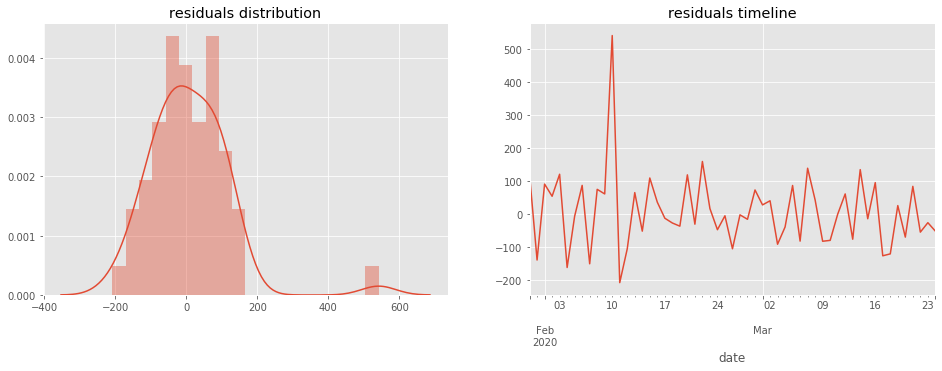

In [35]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
pred = model.predict(test)
pred[pred < 0] = 0
pred = np.square(pred)
print(len(pred), len(test))
print('MSE:', mean_squared_error(pred, test['drivers']))
print('AMSE:', mean_squared_error(pred, test['drivers']) / len(test))
resid = pred - test['drivers']
sns.distplot(resid, bins=20, ax = axes[0]);
axes[0].set_title('residuals distribution')
resid.plot(ax=axes[1]);
axes[1].set_title('residuals timeline');

In [36]:
err = resid.abs().sort_values(ascending=False)
err = resid[err > 200]
err

date
2020-02-10    542.013696
2020-02-11   -208.537414
dtype: float64

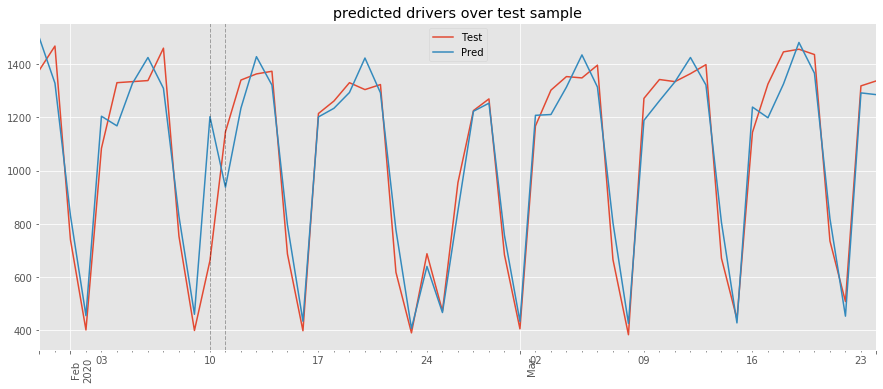

In [37]:
df_pred = pd.DataFrame({'Test': test['drivers'], 'Pred': pred}, index=dates_test)
df_pred.plot(figsize=(15,6));
for idx, e in err.items():
    plt.axvline(idx, color='black', ls='--', lw=1, alpha=0.3)
plt.xticks(rotation=90);
plt.title('predicted drivers over test sample');

### Let's see what happens with rejected and cancelled requested jobs

In [38]:
# TODO: think if it must count number of rows or number or other thing
# because there are itinerary_id that could be exposed to more drivers
# Trim first and last dates because they contain partial information
df_r = careful_query("""
SELECT DATE(sent) as date, COUNT(1) as rejecteds
FROM rejected
WHERE sent > '2019-10-02' AND sent < '2020-03-25'
GROUP BY DATE(sent), distribution_center
HAVING distribution_center = '{0}'
ORDER BY date
""".format(agency['1']), 2250000)

TODO: use this query instead. Maybe it is more useful.
```mysql
SELECT t.date,
       SUM(t.rejected) AS rejected,
	   COUNT(1) AS itineraries,	   
       AVG(CAST(t.rejected AS NUMERIC)) AS avg_rejected,
	   STDDEV(CAST(t.rejected AS NUMERIC)) AS std_rejected
FROM
	(SELECT DATE(sent) AS date, itinerary_id, COUNT(1) AS rejected
	FROM rejected
	WHERE sent > '2019-10-02' AND sent < '2020-03-25'
	GROUP BY distribution_center, DATE(sent), itinerary_id
	HAVING distribution_center = '{0}'
	) t
GROUP BY t.date
ORDER by date ASC
LIMIT 10
```

In [39]:
df_r['date'] = pd.to_datetime(df_r['date'])
df_r.set_index('date', inplace=True)

In [40]:
df_r.head()

,rejecteds
date,
2019-10-02,4470
2019-10-03,3492
2019-10-04,6038
2019-10-05,3759
2019-10-06,6196


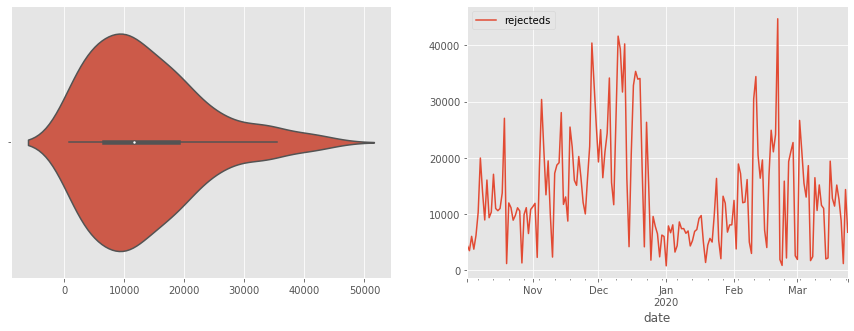

In [41]:
plt.figure(figsize=(15,5))
sns.violinplot(df_r, ax=plt.subplot(121))
df_r.plot(ax=plt.subplot(122));

In [42]:
# Trim first and last dates because they contain partial information
df_c = careful_query("""
SELECT DATE(sent) as date, COUNT(1) as cancelled
FROM unmatched
WHERE sent > '2019-10-02' AND sent < '2020-03-25'
GROUP BY DATE(sent), distribution_center
HAVING distribution_center = '{0}'
ORDER BY date
""".format(agency['1']), 2250000)

In [43]:
df_c['date'] = pd.to_datetime(df_c['date'])
df_c.set_index('date', inplace=True)

In [44]:
df_c.head()

,cancelled
date,
2019-10-02,814
2019-10-03,811
2019-10-04,1146
2019-10-05,714
2019-10-06,700


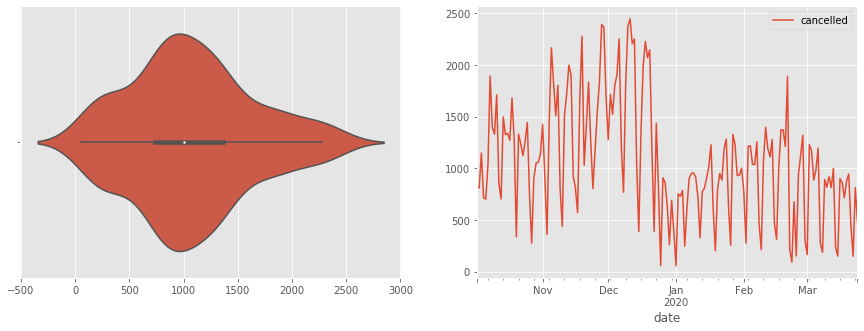

In [45]:
plt.figure(figsize=(15,5))
sns.violinplot(df_c, ax=plt.subplot(121))
df_c.plot(ax=plt.subplot(122));

The right plot above looks like Loggi has made some improvement to their driver selection algorithm in 2020. Maybe the used the quite gap period of the new year to make the system update. Decrement curve in march could be highly correlated with covid19. In february 26th appeared the first covid case in Sao Paulo.

In [46]:
# We don't account with the global number of itineraries by day. But we could use the PRO type
# number normalized as a proxy for the real number of itineries.
df_i = careful_query("""
SELECT DATE(created_time) as date, COUNT(1) as itineraries
FROM itinerary
WHERE created_time > '2019-10-02' AND created_time < '2020-03-25'
GROUP BY distribution_center, DATE(created_time)
HAVING distribution_center = '{0}'
ORDER BY date
""".format(agency['1']))

In [47]:
df_i['date'] = pd.to_datetime(df_i['date'])
df_i.set_index('date', inplace=True)

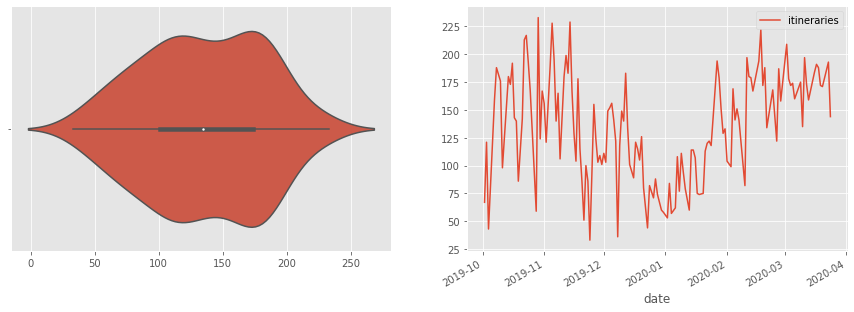

In [48]:
plt.figure(figsize=(15,5))
sns.violinplot(df_i, ax=plt.subplot(121))
df_i.plot(ax=plt.subplot(122));

In [106]:
df_i.head()

,itineraries
date,
2019-10-02,67
2019-10-03,121
2019-10-04,43
2019-10-07,159
2019-10-08,188


Itineraries are kissing Loggi!

#### Ploting all together

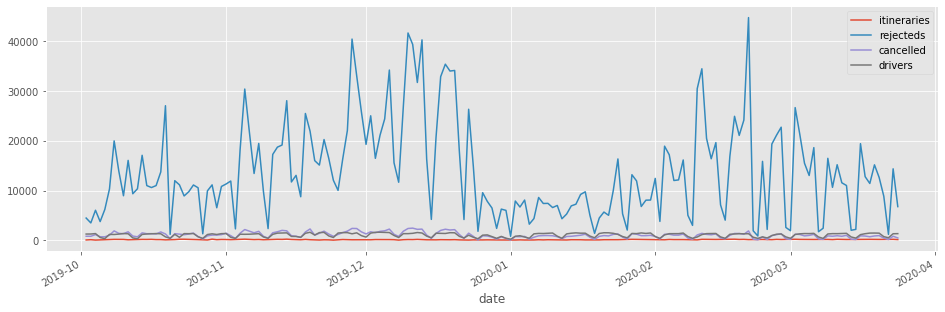

In [49]:
df_i.itineraries.plot(figsize=(16,5))
df_r.rejecteds.plot(figsize=(16,5))
df_c.cancelled.plot(figsize=(16,5))
df.drivers.plot(figsize=(16,5));
plt.legend();

Number of daily rejected jobs is out of scale, so let's see the plot without rejecteds

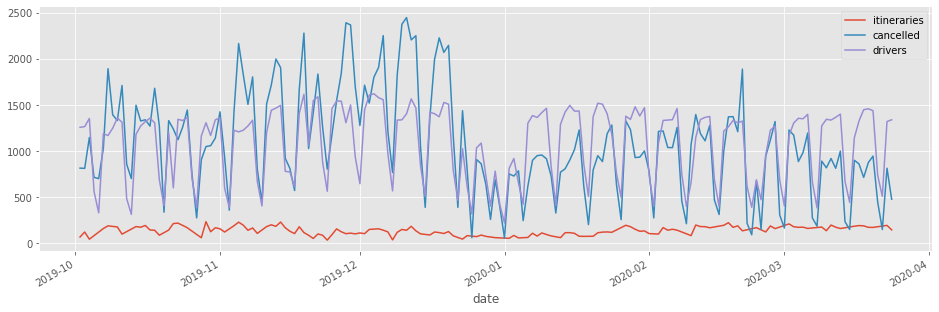

In [50]:
# Same without rejected to facilitate comparison of real values
df_i.itineraries.plot(figsize=(16,5))
df_c.cancelled.plot(figsize=(16,5))
df.drivers.plot(figsize=(16,5));
plt.legend();

And now we normalize all this values for better comparison

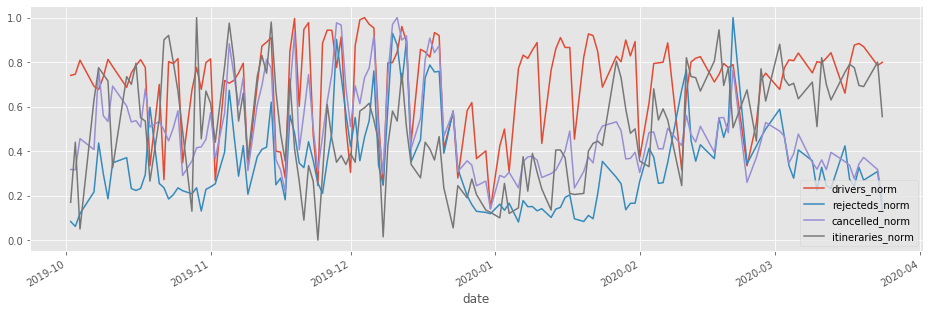

In [51]:
# merge dataframe into a normalized one
dfn = pd.concat([pd.DataFrame(df['drivers']), df_r, df_c, df_i], axis=1)
for col in dfn.columns:
    if col in ['date']: continue
    # normalize
    dfn[col + '_norm'] = (dfn[col]-dfn[col].min())/(dfn[col].max()-dfn[col].min())
    del dfn[col]
dfn.dropna(inplace=True)
dfn.plot(figsize=(16,5));


The above plot is a little uggly, but it shows hugh positive correlation. Let's plot the correlation matrix.

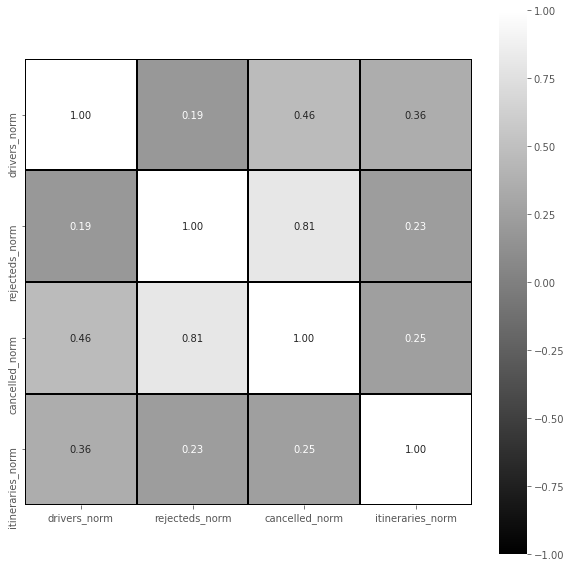

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(dfn.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

One could be expecting the more the drivers the less the rejected or cancelled. But maybe:
- the more the drivers, the more the work
- the more the work, the more the requested messages
- the more the requested messages, the more the rejected messages.

TODO:
- To mix the above rejected and cancelled plot with weather information
- ...

In [53]:
# The file was generated by the weather script.
filename = '../data/weather_daily_2019-10-01_2020-03-25.json'

if not os.path.exists(filename):
    raise 'file not exists'

with open(filename) as f:
    data = json.load(f)

In [54]:
# json into dataframe
df_w = pd.DataFrame(data).T

# will drop any column not listed here
selection = """
summary, icon, precipIntensity, precipProbability,
temperatureHigh, windGust, cloudCover
"""
selection = [col.strip() for col in selection.split(',')]
for col in df_w.columns:
    if col not in selection:
        del df_w[col]
    elif col not in ['summary', 'icon']:
        # set column type to float
        df_w[col] = df_w[col].astype('float')

In [55]:
df_w.index = pd.to_datetime(df_w.index)

In [56]:
# icon string into numeric value
i = {'clear-day': 0, 'partly-cloudy-day':0.33, 'cloudy': 0.67, 'rain': 1}
df_w['iconn'] = df_w['icon'].apply(lambda x: i[x])

In [57]:
# weather dates ranges
df_w.index.min(), df_w.index.max(), len(df_w)

(Timestamp('2019-10-01 00:00:00'), Timestamp('2020-03-25 00:00:00'), 177)

In [58]:
df_w.drop([df_w.index[0], df_w.index[-1]], inplace=True)

In [59]:
dfnw = pd.concat([dfn, df_w], axis=1)

In [60]:
dfnw.head()

,drivers_norm,rejecteds_norm,cancelled_norm,itineraries_norm,summary,icon,precipIntensity,precipProbability,temperatureHigh,windGust,cloudCover,iconn
2019-10-02,0.740186,0.083718,0.317440,0.17,Clear throughout the day.,clear-day,0.0001,0.01,93.04,12.99,0.15,0.0
2019-10-03,0.745896,0.061469,0.316186,0.44,Partly cloudy throughout the day.,clear-day,0.0001,0.01,81.74,17.70,0.25,0.0
2019-10-04,0.808708,0.119389,0.456294,0.05,Clear throughout the day.,clear-day,0.0002,0.01,86.68,15.25,0.22,0.0
2019-10-05,NaN,NaN,NaN,NaN,Clear throughout the day.,clear-day,0.0002,0.04,90.81,16.14,0.04,0.0
2019-10-06,NaN,NaN,NaN,NaN,Light rain overnight.,rain,0.0021,0.43,72.30,18.70,0.85,1.0


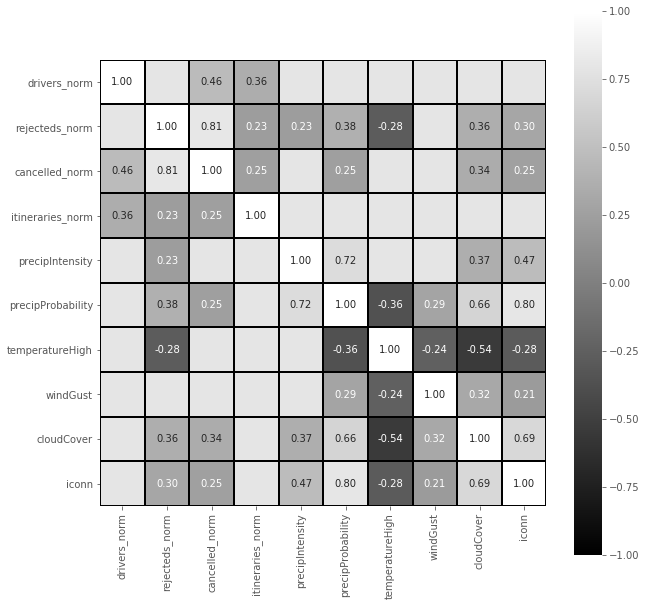

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(dfnw.corr()[dfnw.corr().abs() > 0.2], vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

- **rejecteds**:
  - positive correlated: cancelled, drivers, precipProbability, cloudCover
  - negative correlated: temperatureHigh
- **cancelled**:
  - positive correlated: rejecteds, drivers, cloudCover, precipProbability

So, if we need some of rain for the fields, we could ask Loggi's drivers to reject more itineraries (I couldn't resist it :D)

## Can we build a model to predict number of rejected or cancelled requests?

In [62]:
df_Xy = df[['drivers']].copy()

In [63]:
df_Xy = pd.concat([df_Xy, df_r, df_w[['precipProbability']]], axis=1)

In [64]:
df_Xy['rejected_prev_day'] = df_Xy['rejecteds']
keep = df_Xy.index
df_Xy.reset_index(inplace=True, drop=False)

for i in range(1, len(df_Xy)):
    df_Xy.loc[i, 'rejected_prev_day'] = df_Xy.loc[i-1, 'rejecteds']

df_Xy.set_index('index', inplace=True, drop=True)
df_Xy.head()

,drivers,rejecteds,precipProbability,rejected_prev_day
index,,,,
2019-10-02,1256,4470,0.01,4470
2019-10-03,1264,3492,0.01,4470
2019-10-04,1352,6038,0.01,3492
2019-10-05,561,3759,0.04,6038
2019-10-06,329,6196,0.43,3759


In [65]:
df_Xy.shape

(175, 4)

In [66]:
# We have 175 days, so we will use 120 to train the model
train = df_Xy[:120]
test = df_Xy[120:]
dates = df_Xy.index.tolist()
dates_train = dates[:120]
dates_test = dates[120:]

In [67]:
formula = 'rejecteds ~ ' + ' + '.join([col for col in df_Xy if col not in ['rejecteds']])
print(formula)
model = smf.ols(formula = formula, data = train).fit()
print(model.summary())

rejecteds ~ drivers + precipProbability + rejected_prev_day
                            OLS Regression Results                            
Dep. Variable:              rejecteds   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     62.07
Date:                Mon, 04 May 2020   Prob (F-statistic):           5.19e-24
Time:                        00:40:50   Log-Likelihood:                -1215.1
No. Observations:                 120   AIC:                             2438.
Df Residuals:                     116   BIC:                             2449.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

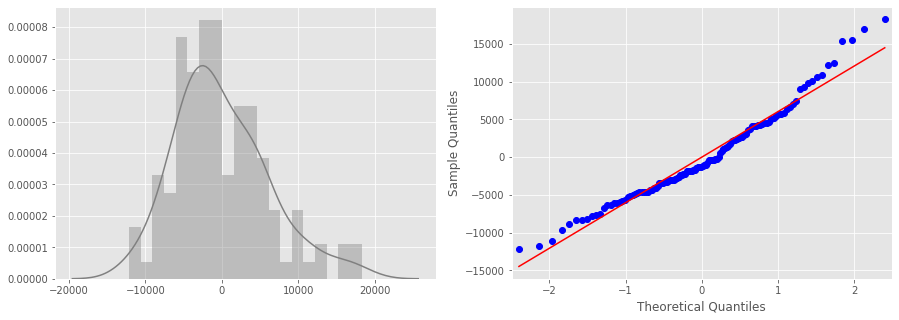

In [68]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(model.resid, bins=20, hist=True, ax=axes[0], color='gray');
idx = model.resid.abs() > model.resid.mean() + 4 * model.resid.std()
sns.rugplot(model.resid[idx], ax=axes[0], color='red')
sm.qqplot(model.resid, line="s", ax=axes[1]);

55 55
MSE: 68979174.73886424
AMSE: 1254166.8134338954


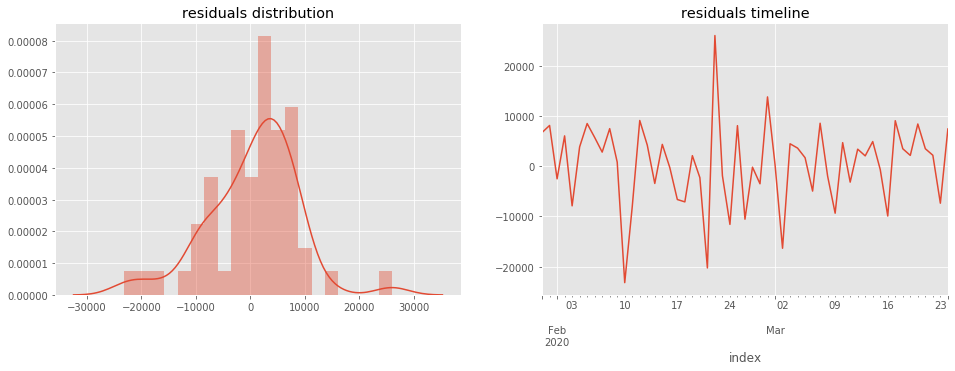

In [69]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
pred = model.predict(test)
#pred[pred < 0] = 0
print(len(pred), len(test))
print('MSE:', mean_squared_error(pred, test['rejecteds']))
print('AMSE:', mean_squared_error(pred, test['rejecteds']) / len(test))
resid = pred - test['rejecteds']
sns.distplot(resid, bins=20, ax = axes[0]);
axes[0].set_title('residuals distribution')
resid.plot(ax=axes[1]);
axes[1].set_title('residuals timeline');

In [70]:
boxcox_help(train['rejecteds'])

'Use np.power(y, λ=0.3)'

**Some useful queries to explore**

```mysql
/* How many itineraries where cancelled at least X times after being accepted */
/* TODO: maybe we can do another version of the query where we count          */
/*       itenerary_id cancelled that are present in itinerary table           */

select count(1) as x1,
       sum(case when t.cancelled >= 2 then 1 else 0 end) as x2,
	   sum(case when t.cancelled >= 5 then 1 else 0 end) as x5,
	   sum(case when t.cancelled >= 10 then 1 else 0 end) as x10,
	   sum(case when t.cancelled >= 15 then 1 else 0 end) as x15,
	   sum(case when t.cancelled >= 20 then 1 else 0 end) as x20,
	   sum(case when t.cancelled >= 25 then 1 else 0 end) as x25,
	   sum(case when t.cancelled >= 30 then 1 else 0 end) as x30
from (
    select itinerary_id, count(1) as cancelled from unmatched
    group by itinerary_id
) t;

/* Number of cancelled per day and the number of distinct itinerary id */
/* that were cancelled by day for a distribution center.               */

select date(sent), count(1), count(distinct(itinerary_id)) from unmatched
where distribution_center = '6e7dacf2149d053183fe901e3cfd8b82'
group by distribution_center, date(sent);


/* Drivers with higher number of cancellations */
/* Why do we keep asking them? */
/* Are they good workers (look for other work metrics)? */

select driver_id, count(1) as cancelled
from unmatched
group by driver_id
order by cancelled desc
limit 10

/* Drivers with higher number of rejections */
/* Why do we keep asking them? */
/* Are they good workers (look for other work metrics)? */

select driver_id, count(1) as rejected
from rejected
group by driver_id
order by rejected desc
limit 10

/* Number of rejections by driver attend type for itineraries pro */

select count(1) as rejected,
	   sum(case when d.attend_corp = 't' then 1 else 0 end) as corp,
	   sum(case when d.attend_presto = 't' then 1 else 0 end) as presto,
	   sum(case when d.attend_pro = 't' then 1 else 0 end) as pro
from itinerary i
join rejected r
on i.itinerary_id = r.itinerary_id
join driver d
on r.driver_id = d.driver_id
where i.distribution_center = '6e7dacf2149d053183fe901e3cfd8b82'
```

In [71]:
# look for rejected behaviour
df_rb = careful_query("""
select count(1) as rejected,
       sum(case when d.attend_corp = 't' then 1 else 0 end) as corp,
       sum(case when d.attend_presto = 't' then 1 else 0 end) as presto,
       sum(case when d.attend_pro = 't' then 1 else 0 end) as pro,       
       sum(case when d.attend_corp = 'f' then 1 else 0 end) as no_corp,
       sum(case when d.attend_presto = 'f' then 1 else 0 end) as no_presto,
       sum(case when d.attend_pro = 'f' then 1 else 0 end) as no_pro       
from itinerary i
join rejected r
on i.itinerary_id = r.itinerary_id
join driver d
on r.driver_id = d.driver_id
where r.distribution_center = '{}'
""".format(agency['1']), 300000)

In [72]:
df_id = careful_query("""
select count(1) as itineraries,
       sum(case when d.attend_corp = 't' then 1 else 0 end) as corp,
       sum(case when d.attend_presto = 't' then 1 else 0 end) as presto,
       sum(case when d.attend_pro = 't' then 1 else 0 end) as pro,       
       sum(case when d.attend_corp = 'f' then 1 else 0 end) as no_corp,
       sum(case when d.attend_presto = 'f' then 1 else 0 end) as no_presto,
       sum(case when d.attend_pro = 'f' then 1 else 0 end) as no_pro       
from itinerary i
join driver d
on i.driver_id = d.driver_id
where i.distribution_center = '{}'
""".format(agency['1']), 300000)

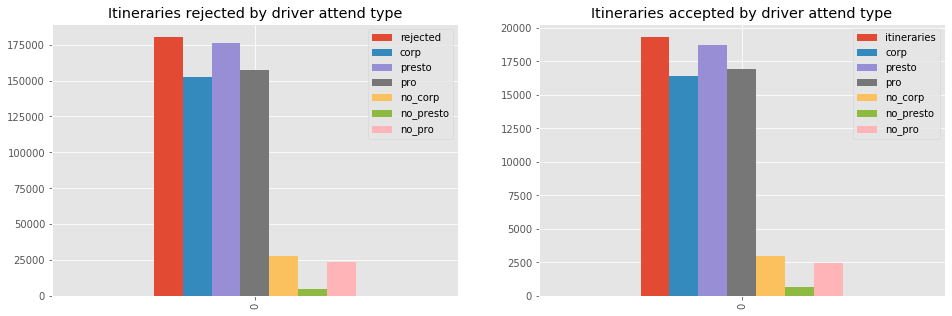

In [73]:
plt.figure(figsize=(16,5))
ax=plt.subplot(121)
df_rb.plot.bar(ax=ax)
ax.set_title('Itineraries rejected by driver attend type')
ax=plt.subplot(122)
df_id.plot.bar(ax=ax)
ax.set_title('Itineraries accepted by driver attend type');

The drivers that reject itineraries are similar to those who accept them when looking at them by attend type

In [74]:
dft = careful_query('select * from driver')
available = dft.notna().sum() / len(dft)
for col, v in available.items():
    if v > 0.99:
        print(col, v)
    else:
        dft.drop(columns={col}, inplace=True)
    

driver_id 1.0
created 1.0
transport_type 1.0
city 0.9999546320660557
operational_status 1.0
email_is_verified 1.0
vehicle_license_plate_type 1.0
cnh_status 1.0
vehicle_status 1.0
has_all_documents_valid 1.0
first_itinerary_id 1.0
attend_corp 1.0
attend_presto 1.0
attend_pro 1.0


In [75]:
dft.loc[dft.city.isna(), 'city'] = 'unknown'

In [76]:
assert all(dft.notna().sum() / len(dft) == 1)

In [77]:
dft.nunique()

driver_id                     22029
created                       22022
transport_type                    3
city                             22
operational_status                7
email_is_verified                 2
vehicle_license_plate_type        2
cnh_status                        4
vehicle_status                    4
has_all_documents_valid           2
first_itinerary_id            20003
attend_corp                       2
attend_presto                     2
attend_pro                        2
dtype: int64

In [78]:
dft.transport_type.unique()

array(['Moto', 'Van', 'Carro'], dtype=object)

In [79]:
# look for rejected behaviour
df_rb = careful_query("""
select count(1) as rejected,
       sum(case when d.transport_type = 'Moto' then 1 else 0 end) as moto,
       sum(case when d.transport_type = 'Van' then 1 else 0 end) as van,
       sum(case when d.transport_type = 'Carro' then 1 else 0 end) as carro       
from itinerary i
join rejected r
on i.itinerary_id = r.itinerary_id
join driver d
on r.driver_id = d.driver_id
where r.distribution_center = '{}'
""".format(agency['1']), 300000)

In [80]:
df_id = careful_query("""
select count(1) as itineraries,
       sum(case when d.transport_type = 'Moto' then 1 else 0 end) as moto,
       sum(case when d.transport_type = 'Van' then 1 else 0 end) as van,
       sum(case when d.transport_type = 'Carro' then 1 else 0 end) as carro       
from itinerary i
join driver d
on i.driver_id = d.driver_id
where i.distribution_center = '{}'
""".format(agency['1']), 300000)

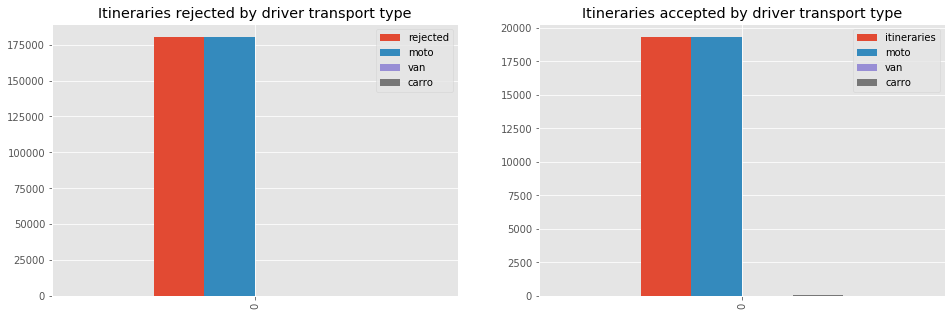

In [81]:
plt.figure(figsize=(16,5))
ax=plt.subplot(121)
df_rb.plot.bar(ax=ax)
ax.set_title('Itineraries rejected by driver transport type')
ax=plt.subplot(122)
df_id.plot.bar(ax=ax)
ax.set_title('Itineraries accepted by driver transport type');

In [82]:
dft = careful_query("""
select i.itinerary_id, count(1) as rejected
from itinerary i
join rejected r
on i.itinerary_id = r.itinerary_id
join driver d
on r.driver_id = d.driver_id
where i.distribution_center = '{}'
group by i.itinerary_id
order by rejected desc
limit 10
""".format(agency['1']), 300000)

In [83]:
dft

,itinerary_id,rejected
0,b8dc41bff4c8f29b0882bfb93d3abf45,199
1,4797605de17a2ee140b65d981561222d,160
2,fddac0daaab2e681cbf3c638cc7e9e5c,159
3,14803537f6f5b2af51cc20e47891a5b4,155
4,42c57f4f6a1c137f6ee5bc0415a02547,154
5,b292345bcc1010332f59078b899e8ec7,146
6,054ef19c350e6035998fed2df6b2a725,139
7,5c7df1e0aacedacebd7b3e9325bbcafc,138
8,3e392f35c8cf1af671a8338c5b277828,131
9,e0c652c666abb49ffa76e9bd800de2d3,130


In [84]:
dft = careful_query("""
select driver_id, sent from rejected
where itinerary_id = 'b8dc41bff4c8f29b0882bfb93d3abf45'
order by sent
""")

In [85]:
dft.sent.min(), dft.sent.max()


(Timestamp('2019-10-23 16:50:03'), Timestamp('2019-10-24 06:36:40'))

In [86]:
dft

,driver_id,sent
0,d42afded825dcfdab2b840f80fb9bf66,2019-10-23 16:50:03
1,51e3fb34a0495f9e33c2c141aef74442,2019-10-23 16:52:13
2,1fbf7df98c038455205af2dec3f1165c,2019-10-23 16:55:16
3,cf3e0fe083e5f869d87f7093d80e3c1e,2019-10-23 16:56:11
4,cf3e0fe083e5f869d87f7093d80e3c1e,2019-10-23 16:56:11
...,...,...
194,3e5b3c00db5cd07038a1f612efb1ccad,2019-10-24 06:24:04
195,0c97c62a9576a6b957db3bf80bd3ce22,2019-10-24 06:24:21
196,d7eb8de8f2dc205c8446c2b0ea66c9d7,2019-10-24 06:30:47
197,88fd24938a09c17d82f38b27b770898f,2019-10-24 06:32:03


```mysql
/* What are the odds between accept and reject per driver */
select  t.driver_id,
        t.itineraries,
		count(1) as rejections,
		ROUND(CAST((CAST(t.itineraries as float) / count(1)) AS NUMERIC), 2) as odds
from
	(select driver_id, count(1) as itineraries
	from itinerary i
	group by driver_id
	--order by itineraries desc
	--limit 10) t
	 ) t
join rejected r
on t.driver_id = r.driver_id
group by t.driver_id, t.itineraries
order by odds desc
limit 10


```

In [88]:
df_s = careful_query("""
/* Number of free and busy available slots per day */
/* of drivers in itinerary table */

select date(sent_f) as date,
       count(1) as slots,
       sum(case when ai.availability_id is null then 1 else 0 end) as slots_free,
       sum(case when ai.availability_id is null then 0 else 1 end) as slots_busy
from availability a
left join av2it_2 ai
on a.id = ai.availability_id
left join (
    select distinct(driver_id) as driver_id
    from itinerary
    where distribution_center = '{0}'
) di
on a.driver_id = di.driver_id
where distribution_center = '{0}'
  and di.driver_id is not null
  and sent_f >=  '2019-10-02'
  and sent_f <   '2020-03-25'
group by distribution_center, date(sent_f)
order by distribution_center, date(sent_f) asc
""".format(agency['1']), 1050000)

In [89]:
df_s['date'] = pd.to_datetime(df_s['date'])
df_s.set_index('date', inplace=True)

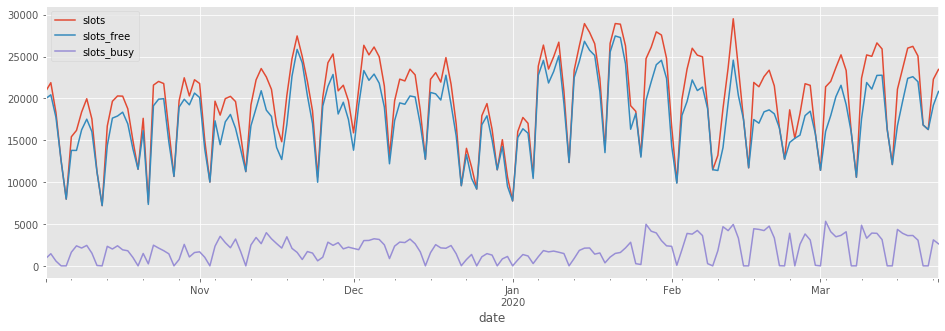

In [90]:
df_s.plot(figsize=(16,5));

In [91]:
dft = pd.concat([dfnw, df_s], axis=1)

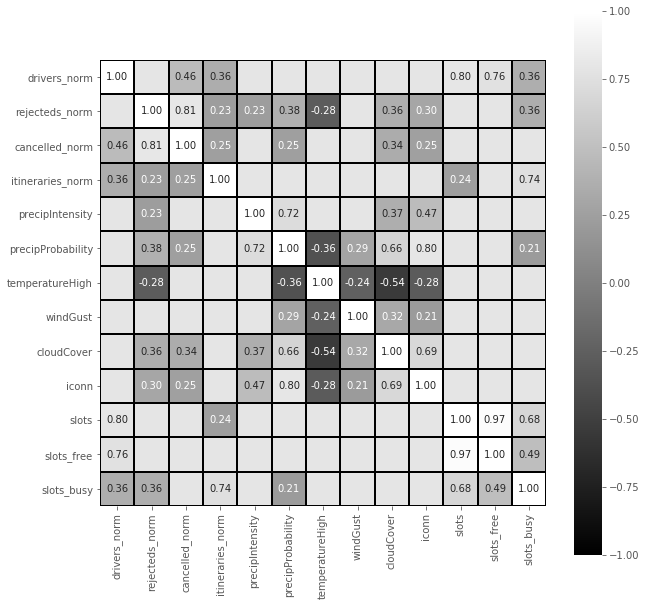

In [92]:
plt.figure(figsize=(10,10))
sns.heatmap(dft.corr()[dft.corr().abs() > 0.2], vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

## Can we improve the model to predict number of rejected or cancelled requests?

In [93]:
df_Xy = df[['drivers']].copy()
df_Xy = pd.concat([df_Xy, df_r, df_w[['precipProbability']],df_s[['slots_free','slots_busy']],], axis=1)

df_Xy['rejected_prev_day'] = df_Xy['rejecteds']
keep = df_Xy.index
df_Xy.reset_index(inplace=True, drop=False)

for i in range(1, len(df_Xy)):
    df_Xy.loc[i, 'rejected_prev_day'] = df_Xy.loc[i-1, 'rejecteds']

df_Xy.set_index('index', inplace=True, drop=True)
df_Xy.head()

,drivers,rejecteds,precipProbability,slots_free,slots_busy,rejected_prev_day
index,,,,,,
2019-10-02,1256,4470,0.01,19975,876,4470
2019-10-03,1264,3492,0.01,20429,1448,4470
2019-10-04,1352,6038,0.01,17735,571,3492
2019-10-05,561,3759,0.04,12571,0,6038
2019-10-06,329,6196,0.43,7971,0,3759


In [94]:
df_Xy.shape

(175, 6)

In [95]:
# We have 175 days, so we will use 120 to train the model
train = df_Xy[:120]
test = df_Xy[120:]
dates = df_Xy.index.tolist()
dates_train = dates[:120]
dates_test = dates[120:]

In [96]:
formula = 'rejecteds ~ ' + ' + '.join([col for col in df_Xy if col not in ['rejecteds']])
print(formula)
model = smf.ols(formula = formula, data = train).fit()
print(model.summary())


rejecteds ~ drivers + precipProbability + slots_free + slots_busy + rejected_prev_day
                            OLS Regression Results                            
Dep. Variable:              rejecteds   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     56.53
Date:                Mon, 04 May 2020   Prob (F-statistic):           2.78e-29
Time:                        00:44:50   Log-Likelihood:                -1197.7
No. Observations:                 120   AIC:                             2407.
Df Residuals:                     114   BIC:                             2424.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

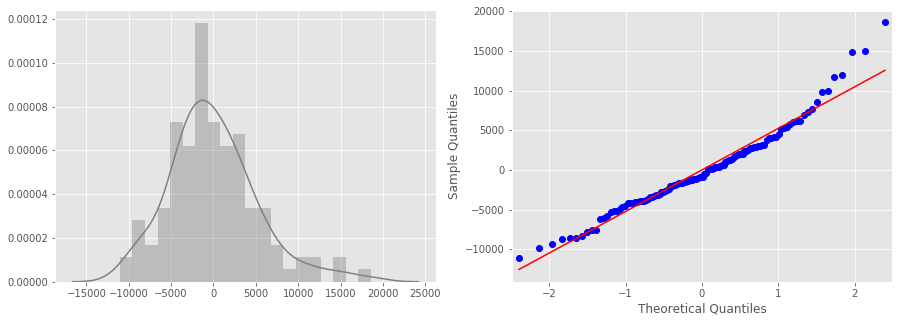

In [97]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(model.resid, bins=20, hist=True, ax=axes[0], color='gray');
idx = model.resid.abs() > model.resid.mean() + 4 * model.resid.std()
sns.rugplot(model.resid[idx], ax=axes[0], color='red')
sm.qqplot(model.resid, line="s", ax=axes[1]);

55 55
MSE: 43127687.96087778


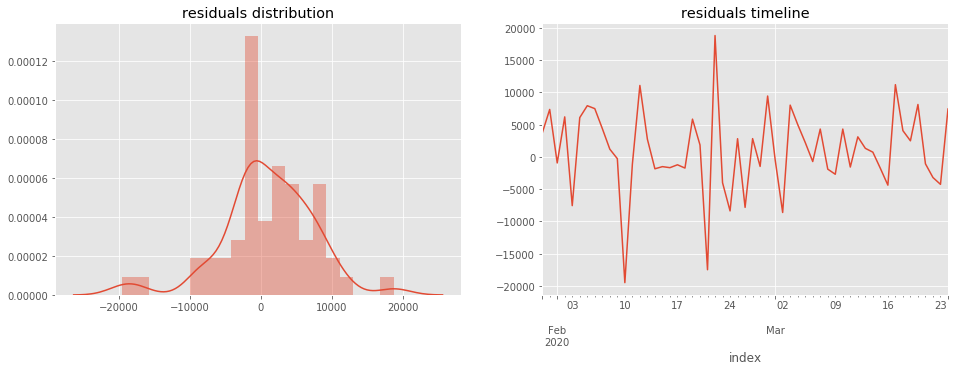

In [98]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
pred = model.predict(test)
#pred[pred < 0] = 0
print(len(pred), len(test))
print('MSE:', mean_squared_error(pred, test['rejecteds']))
resid = pred - test['rejecteds']
sns.distplot(resid, bins=20, ax = axes[0]);
axes[0].set_title('residuals distribution')
resid.plot(ax=axes[1]);
axes[1].set_title('residuals timeline');

In [123]:
df_ir = careful_query("""
select date(i.created_time) as date,
       count(1) as itineraries,
       cast(avg(i.distance) as float) as avg_distance,
       cast(stddev(i.distance) as float) as std_distance,
       cast(avg(i.packages) as float) as avg_packages,
       cast(stddev(i.packages) as float) as std_packages,
       cast(avg(i.delivered_packages) as float) as avg_delivered_packages,
       cast(stddev(i.delivered_packages) as float) as std_delivered_packages,
       cast(avg(ir.rejections) as float) as avg_rejections,
       cast(stddev(ir.rejections) as float) as std_rejections
from itinerary i
join
    (select i.itinerary_id,
        sum(case when r.itinerary_id is null then 0 else 1 end) as rejections
    from itinerary i
    join rejected r
    on i.itinerary_id = r.itinerary_id
    where i.distribution_center = '{0}'
      and i.created_time  >= '2019-10-02'
      and i.created_time < '2020-03-25'
    group by i.itinerary_id) ir
on i.itinerary_id = ir.itinerary_id
where i.distribution_center = '{0}'
  and i.created_time  >= '2019-10-02'
  and i.created_time < '2020-03-25'
group by date(i.created_time)
order by date asc
""".format(agency['1']), 250000)

In [124]:
df_ir['date'] = pd.to_datetime(df_ir['date'])
df_ir.set_index('date', inplace=True)

In [125]:
df_ir.head()

,itineraries,avg_distance,std_distance,avg_packages,std_packages,avg_delivered_packages,std_delivered_packages,avg_rejections,std_rejections
date,,,,,,,,,
2019-10-02,6,23598.166667,13165.361194,4.333333,3.983298,3.166667,3.371449,2.666667,1.032796
2019-10-03,35,30567.714286,13438.274225,10.057143,4.595028,9.342857,4.645952,6.114286,4.316667
2019-10-04,18,27860.055556,12956.033128,10.388889,5.658298,9.777778,5.440108,5.111111,5.799482
2019-10-07,114,29752.201754,13939.848014,7.394737,2.776700,6.824561,2.804060,7.798246,7.656543
2019-10-08,162,33415.228395,16838.026555,9.117284,3.406945,8.407407,3.564064,13.438272,11.980285


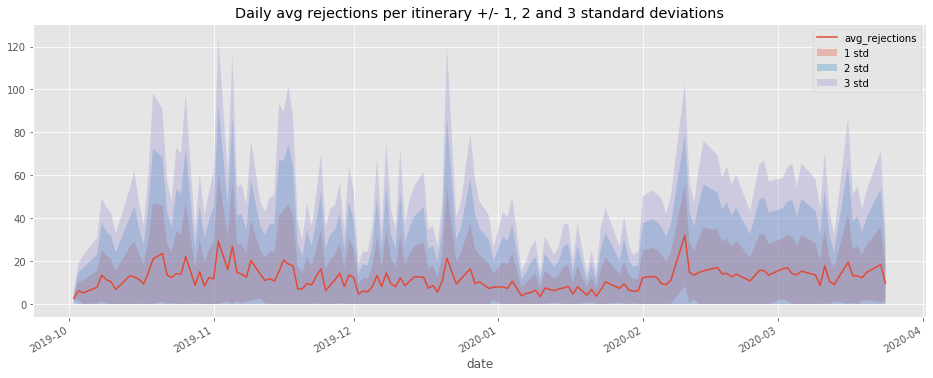

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
for std in [1, 2, 3]:
    ax.fill_between(df_ir.index,
                 df_ir.avg_rejections + std*df_ir.std_rejections,
                 [max(0, y) for y in (df_ir.avg_rejections - std*df_ir.std_rejections)],
                 alpha = 0.3,
                   label='{} std'.format(std))
df_ir.avg_rejections.plot(ax=ax)
plt.legend()
ax.set_title('Daily avg rejections per itinerary +/- 1, 2 and 3 standard deviations');

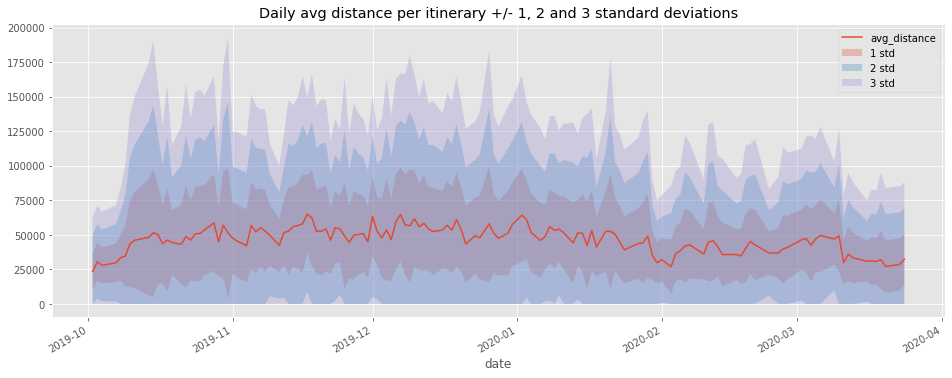

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
for std in [1, 2, 3]:
    ax.fill_between(df_ir.index,
                 df_ir.avg_distance + std*df_ir.std_distance,
                 [max(0, y) for y in (df_ir.avg_distance - std*df_ir.std_distance)],
                 alpha = 0.3,
                   label='{} std'.format(std))
df_ir.avg_distance.plot(ax=ax)
plt.legend()
ax.set_title('Daily avg distance per itinerary +/- 1, 2 and 3 standard deviations');

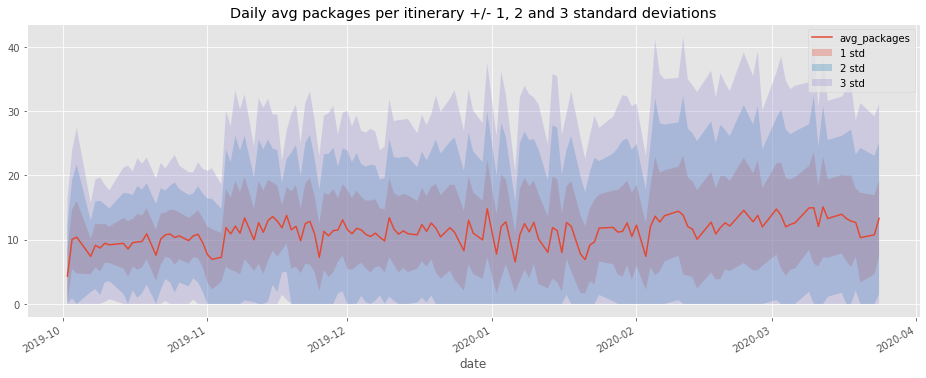

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
for std in [1, 2, 3]:
    ax.fill_between(df_ir.index,
                 df_ir.avg_packages + std*df_ir.std_packages,
                 [max(0, y) for y in (df_ir.avg_packages - std*df_ir.std_packages)],
                 alpha = 0.3,
                   label='{} std'.format(std))
df_ir.avg_packages.plot(ax=ax)
plt.legend()
ax.set_title('Daily avg packages per itinerary +/- 1, 2 and 3 standard deviations');

In [128]:
df_ir['avg_delivered_ratio'] = df_ir['avg_delivered_packages'] / df_ir['avg_packages']

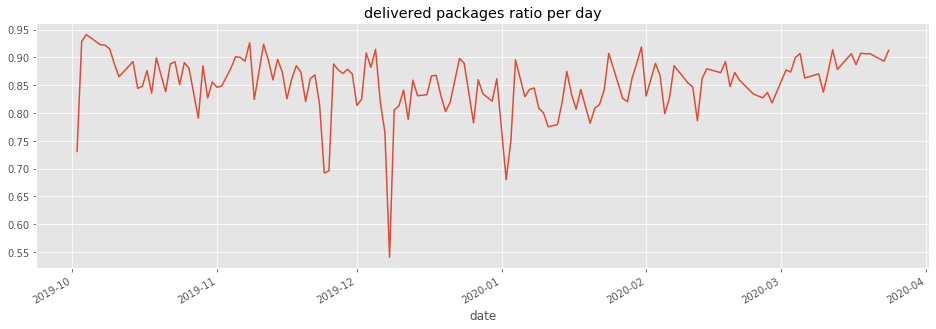

In [131]:
df_ir.avg_delivered_ratio.plot(figsize=(16,5))
plt.title('delivered packages ratio per day');

In [132]:
sel = ['drivers_norm', 'rejecteds_norm', 'cancelled_norm', 'itineraries_norm', 'precipProbability']
dft = pd.concat([dfnw[sel], df_s, df_ir], axis=1)

In [133]:
dft.dropna(inplace=True)

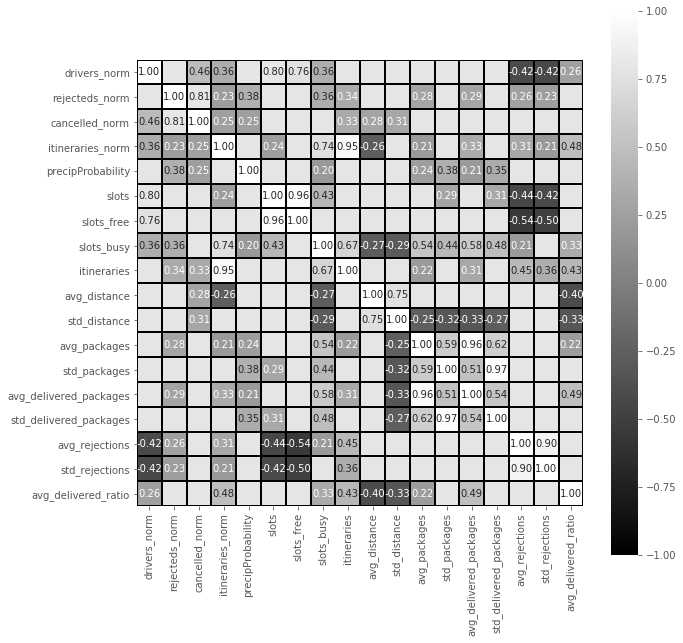

In [134]:
plt.figure(figsize=(10,10))
sns.heatmap(dft.corr()[dft.corr().abs() > 0.2], vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

### Does the distance affect the rejection of an itinerary?
Maybe we could classify itineraries by some pre defined distances: < 10000 < 20000 < 30000 < 40000 < 50000 < 60000 >= 60000
And the count the avg number of rejections per cluster

Or maybe we could check the correlation between pair of distance, rejections of all itineraries

In [264]:
df_idr = careful_query("""
select i.distance, i.packages, i.waypoints, ir.rejections
from itinerary i
join
    (select itinerary_id, count(1) as rejections
    from rejected
    where distribution_center = '{0}'
      and sent >= '2019-10-02'
      and sent <  '2020-03-25'
    group by itinerary_id
    ) ir
on i.itinerary_id = ir.itinerary_id
where distribution_center = '{0}'
  and created_time >= '2019-10-02'
  and created_time <  '2020-03-25'
""".format(agency['1']), 500000)

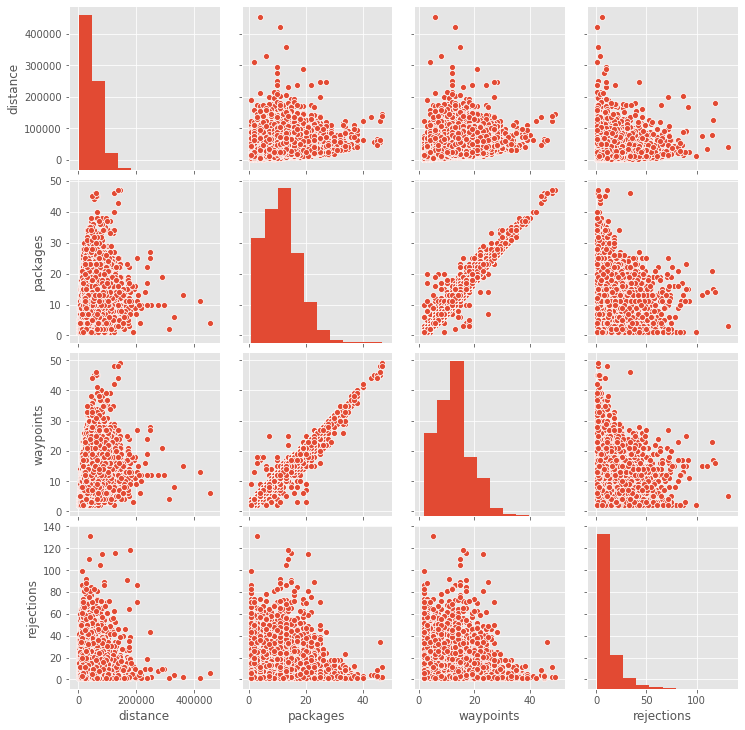

In [265]:
sns.pairplot(df_idr);

Incredible. Rejections does not look correlated with distance. The only logical correlation here are number of packages with number of waypoints.

Possible variables that could be related with rejections:
- distance from driver to agency when received notification
- hour of the notification
- destiny location of the itinerary

**itinerary global hourly view**

In [199]:
df_ih = pd.DataFrame({'hour' : [i for i in range(24)]})

columns = ['created_time', 'accepted_time', 'started_time', 'pickup_checkout_time', 'finished_time']
            #'checked_in_time', , 

for col in columns:

    df_iha = careful_query("""
        select extract(hour from i.{1}) as hour, count(1) as {1} from itinerary i
        where distribution_center = '{0}'
          and {1} is not null
        group by hour
        order by hour asc
        """.format(agency['1'], col))

    df_iha['hour'] = df_iha['hour'].astype('int') 
    df_iha.set_index('hour', inplace=True)

    df_ih = pd.concat([df_ih, df_iha], axis=1)

del df_ih['hour']

In [202]:
df_ih['created_minus_finished'] = df_ih['created_time'] - df_ih['finished_time']

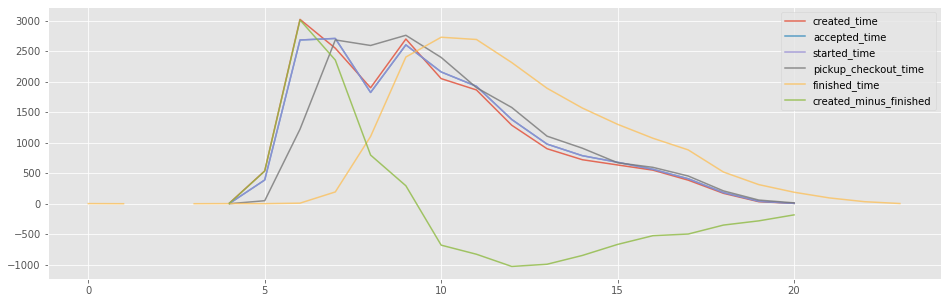

In [203]:
df_ih.plot(alpha=0.8, figsize=(16,5));

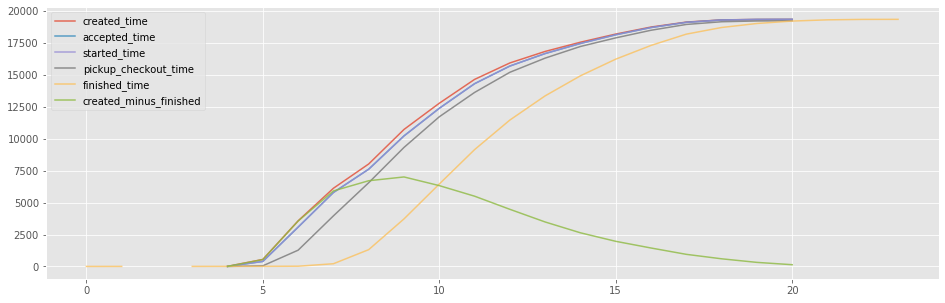

In [204]:
df_ih.cumsum().plot(alpha=0.8, figsize=(16,5));

Maybe Vikram is right with the idea to use ODE with this.

**Recalculate itineraries statuses**

In [207]:
df_s = careful_query("""
select i.itinerary_id,
       ir.total_rejection_time,
       ir.status
from itinerary i
join
    (select itinerary_id,
           count(1) as rejections,
            min(sent) as first_rejection,
            max(sent) as last_rejection,
            (max(sent) - min(sent)) as total_rejection_time, /* I should include the accepted time */
            (case
                when max(sent) - min(sent) >= '00:30:00' then 'dropped'
            end) as status
    from rejected
    where distribution_center = '{0}'
    group by itinerary_id
    ) ir
on i.itinerary_id = ir.itinerary_id
where distribution_center = '{0}'
order by total_rejection_time desc
""".format(agency['1']), 500000)

In [208]:
df_s.head()

,itinerary_id,total_rejection_time,status
0,4933c2847f0bb5a2815f91b6aac830a3,122 days 07:42:53,dropped
1,56d8a901ced86e9cb643fc83ecf3781a,27 days 19:41:46,dropped
2,dc5bea6b185b59bd2755c1b5b08f16d1,23 days 20:56:46,dropped
3,831d50a16d96df74d2e7cb06ce812381,23 days 19:07:34,dropped
4,3eb90091c3e26a648c88beec8b3ece1b,23 days 17:40:19,dropped


This does not look possible. Maybe this is some time of collision on itinerary id generation.

In [226]:
# Let use the drop indicator on the last time itinerary was dropped

df_s = careful_query("""
select last_rejected_date as date, sum(tis.status) as dropped
from
    (select ir.last_rejected_date,
           ir.status
    from itinerary i
    join
        (select itinerary_id, date(max(sent)) as last_rejected_date,
                (case  when max(sent) - min(sent) >= '00:30:00' then 1 else 0 end) as status
        from rejected
        where distribution_center = '{0}'
        group by itinerary_id
        ) ir
    on i.itinerary_id = ir.itinerary_id
    where distribution_center = '{0}'
    ) tis
where last_rejected_date >= '2019-10-02'
  and last_rejected_date <  '2020-03-25'
group by last_rejected_date
order by last_rejected_date asc
""".format(agency['1']), 500000)

df_s['date'] = pd.to_datetime(df_s['date'])
df_s.set_index('date', inplace=True)

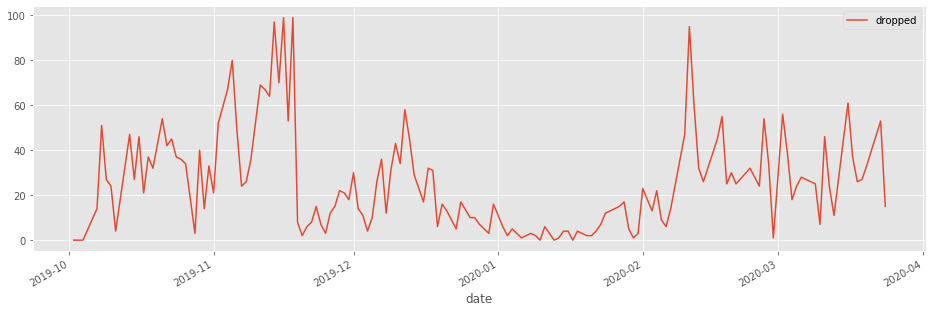

In [227]:
df_s.plot(figsize=(16,5));

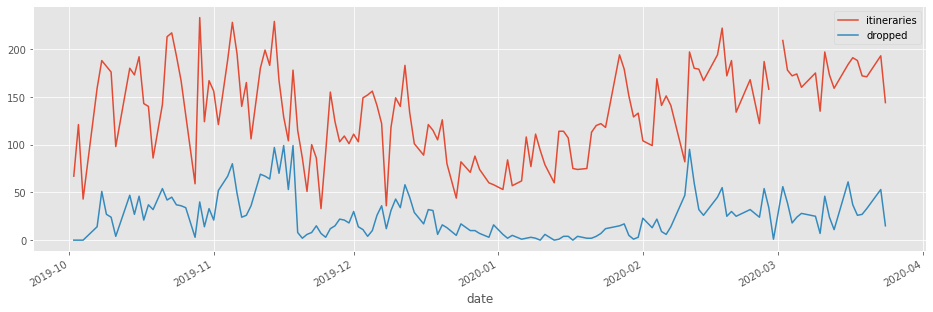

In [228]:
pd.concat([df_i, df_s], axis=1).plot(figsize=(16,5));

In [235]:
dow = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
df['DOW'] = df.index.dayofweek
df_Xy = df[['drivers', 'DOW']].copy()
df_Xy = pd.concat([df_Xy, pd.get_dummies(df_Xy['DOW'], drop_first=True), df_i, df_s], axis=1)
df_Xy = df_Xy.rename(columns={i : dow[i] for i in range(7)})
del df_Xy['DOW']
df_Xy.dropna(inplace=True)

In [236]:
df_Xy['holiday'] = 0

for h in [h[0] for h in holidays]:
    d = pd.to_datetime(h)
    if d in df_Xy.index:
        df_Xy.loc[d, 'holiday'] = 1

In [237]:
df_Xy.head()

,drivers,tuesday,wednesday,thursday,friday,saturday,sunday,itineraries,dropped,holiday
date,,,,,,,,,,
2019-10-02,1256,0,1,0,0,0,0,67.0,0.0,0
2019-10-03,1264,0,0,1,0,0,0,121.0,0.0,0
2019-10-04,1352,0,0,0,1,0,0,43.0,0.0,0
2019-10-07,1188,0,0,0,0,0,0,159.0,14.0,0
2019-10-08,1167,1,0,0,0,0,0,188.0,51.0,0


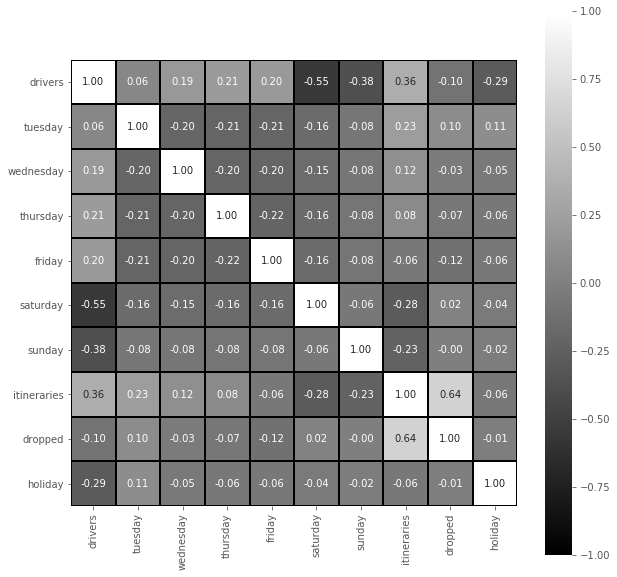

In [238]:
plt.figure(figsize=(10,10))
sns.heatmap(df_Xy.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

In [239]:
df_Xy.shape

(141, 10)

In [240]:
# We have 141 business days, so we will use 100 to train the model
train = df_Xy[:100]
test = df_Xy[100:]
dates = df_Xy.index.tolist()
dates_train = dates[:100]
dates_test = dates[100:]

In [241]:
formula = 'dropped ~ ' + ' + '.join([col for col in df_Xy if col not in ['dropped']])
print(formula)
model = smf.ols(formula = formula, data = train).fit()
print(model.summary())

dropped ~ drivers + tuesday + wednesday + thursday + friday + saturday + sunday + itineraries + holiday
                            OLS Regression Results                            
Dep. Variable:                dropped   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     15.82
Date:                Mon, 04 May 2020   Prob (F-statistic):           3.40e-15
Time:                        12:28:01   Log-Likelihood:                -410.42
No. Observations:                 100   AIC:                             840.8
Df Residuals:                      90   BIC:                             866.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

41 41
MSE: 287.2573790410207


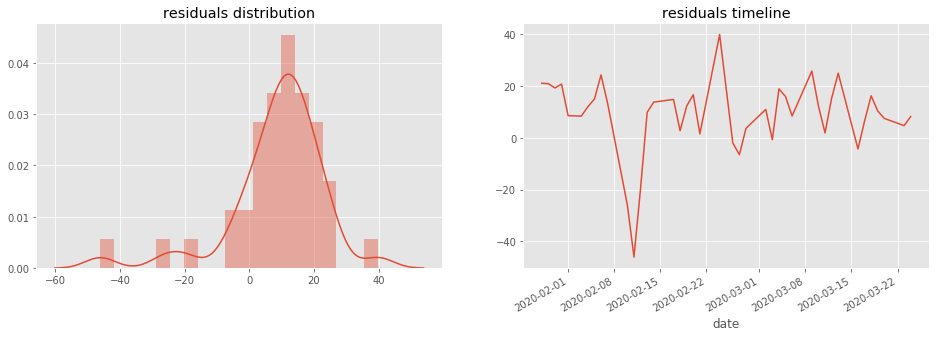

In [246]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
pred = model.predict(test)
pred[pred < 0] = 0
print(len(pred), len(test))
print('MSE:', mean_squared_error(pred, test['dropped']))
resid = pred - test['dropped']
sns.distplot(resid, bins=20, ax = axes[0]);
axes[0].set_title('residuals distribution')
resid.plot(ax=axes[1]);
axes[1].set_title('residuals timeline');

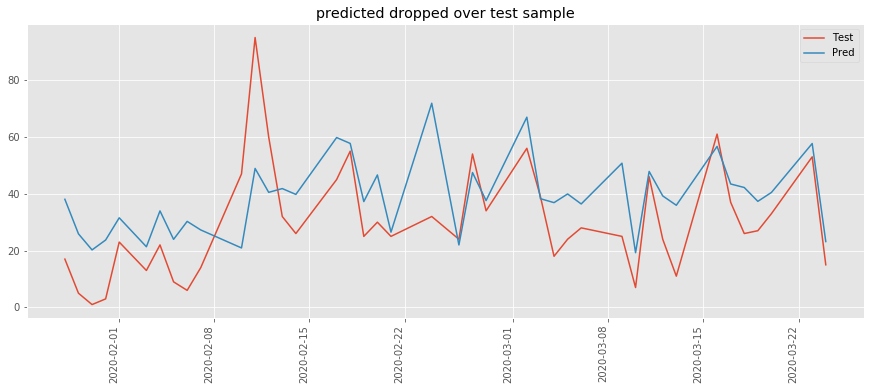

In [247]:
df_pred = pd.DataFrame({'Test': test['dropped'], 'Pred': pred}, index=dates_test)
df_pred.plot(figsize=(15,6));
plt.xticks(rotation=90);
plt.title('predicted dropped over test sample');